### Bank Nifty ARMA-GARCH Model


In [17]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import t # For GARCH model with t-distribution
import matplotlib
import statsmodels
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Statsmodels version: {statsmodels.__version__}")

import warnings
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [18, 10]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Define the path to your Bank Nifty data
data_path = '/home/code/Repos/financial_models/bank_nifty_intraday.csv'
print(f"Data path set to: {data_path}")

Matplotlib version: 3.10.3
Statsmodels version: 0.14.4
Data path set to: /home/code/Repos/financial_models/bank_nifty_intraday.csv


In [18]:
# Cell 2: Data Loading and Preprocessing (Adapted from original notebook)
print("--- Data Loading and Preprocessing ---")

# Load data from CSV
try:
    df = pd.read_csv(data_path)
    print("Bank Nifty data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file was not found at {data_path}. Please check the path.")
    raise # Re-raise to stop execution if file is not found

# Combine 'Date' and 'Time' into a single DateTime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')

# Set 'DateTime' as index and sort
df = df.set_index('DateTime').sort_index()

# Drop 'Instrument' column if it exists and is constant
if 'Instrument' in df.columns:
    df = df.drop(columns=['Instrument'])

print("Original 1-minute data head:")
print(df.head())

# Resample to 15-minute intervals (as per your request)
resample_freq = '15T'
resampled_close = df['Close'].resample(resample_freq).last().dropna()
print(f"\nData resampled to {resample_freq} intervals. Head of resampled Close prices:")
print(resampled_close.head())

# Calculate log returns
log_returns = np.log(resampled_close / resampled_close.shift(1)).dropna()
print("\nLog returns calculated. Head:")
print(log_returns.head())

print(f"Total data points (15-min log returns): {len(log_returns)}")

--- Data Loading and Preprocessing ---
Bank Nifty data loaded successfully.
Original 1-minute data head:
                           Date     Time     Open      High       Low  \
DateTime                                                                
2015-01-09 09:15:00  09-01-2015  9:15:00  18845.9  18845.90  18801.70   
2015-01-09 09:16:00  09-01-2015  9:16:00  18801.7  18806.05  18790.20   
2015-01-09 09:17:00  09-01-2015  9:17:00  18796.0  18829.00  18794.65   
2015-01-09 09:18:00  09-01-2015  9:18:00  18827.3  18864.00  18827.30   
2015-01-09 09:19:00  09-01-2015  9:19:00  18862.1  18862.10  18843.55   

                        Close  
DateTime                       
2015-01-09 09:15:00  18801.70  
2015-01-09 09:16:00  18794.65  
2015-01-09 09:17:00  18827.30  
2015-01-09 09:18:00  18862.10  
2015-01-09 09:19:00  18849.25  

Data resampled to 15T intervals. Head of resampled Close prices:
DateTime
2015-01-09 09:15:00    18815.15
2015-01-09 09:30:00    18771.60
2015-01-09 09:45:00 

--- Plotting Returns Series ---


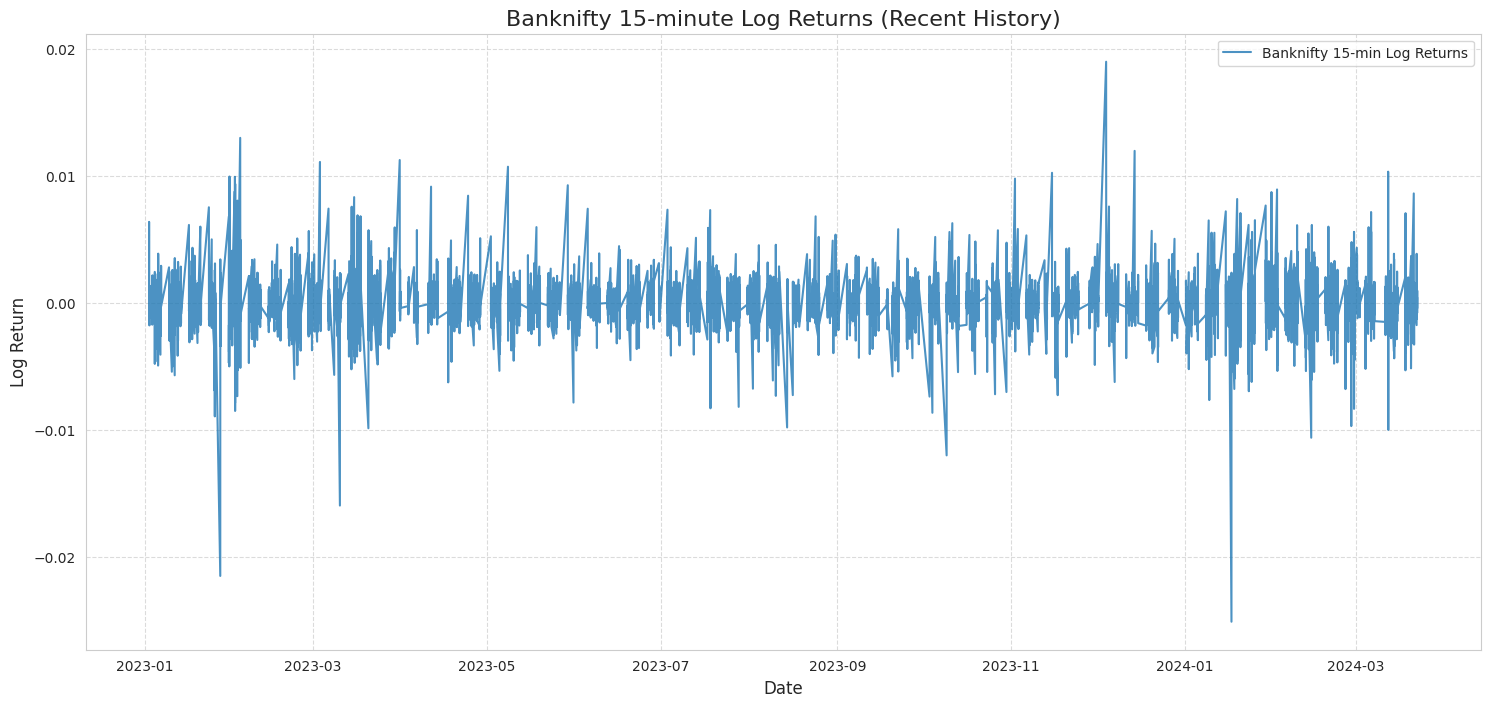

In [19]:
# Cell 3: Plotting the Returns Series (Adapted from original notebook)
print("--- Plotting Returns Series ---")

plt.figure(figsize=(18, 8))
plt.plot(log_returns.loc['2023-01-01':], label='Banknifty 15-min Log Returns', alpha=0.8)
plt.title('Banknifty 15-minute Log Returns (Recent History)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

--- Autocorrelation Analysis ---


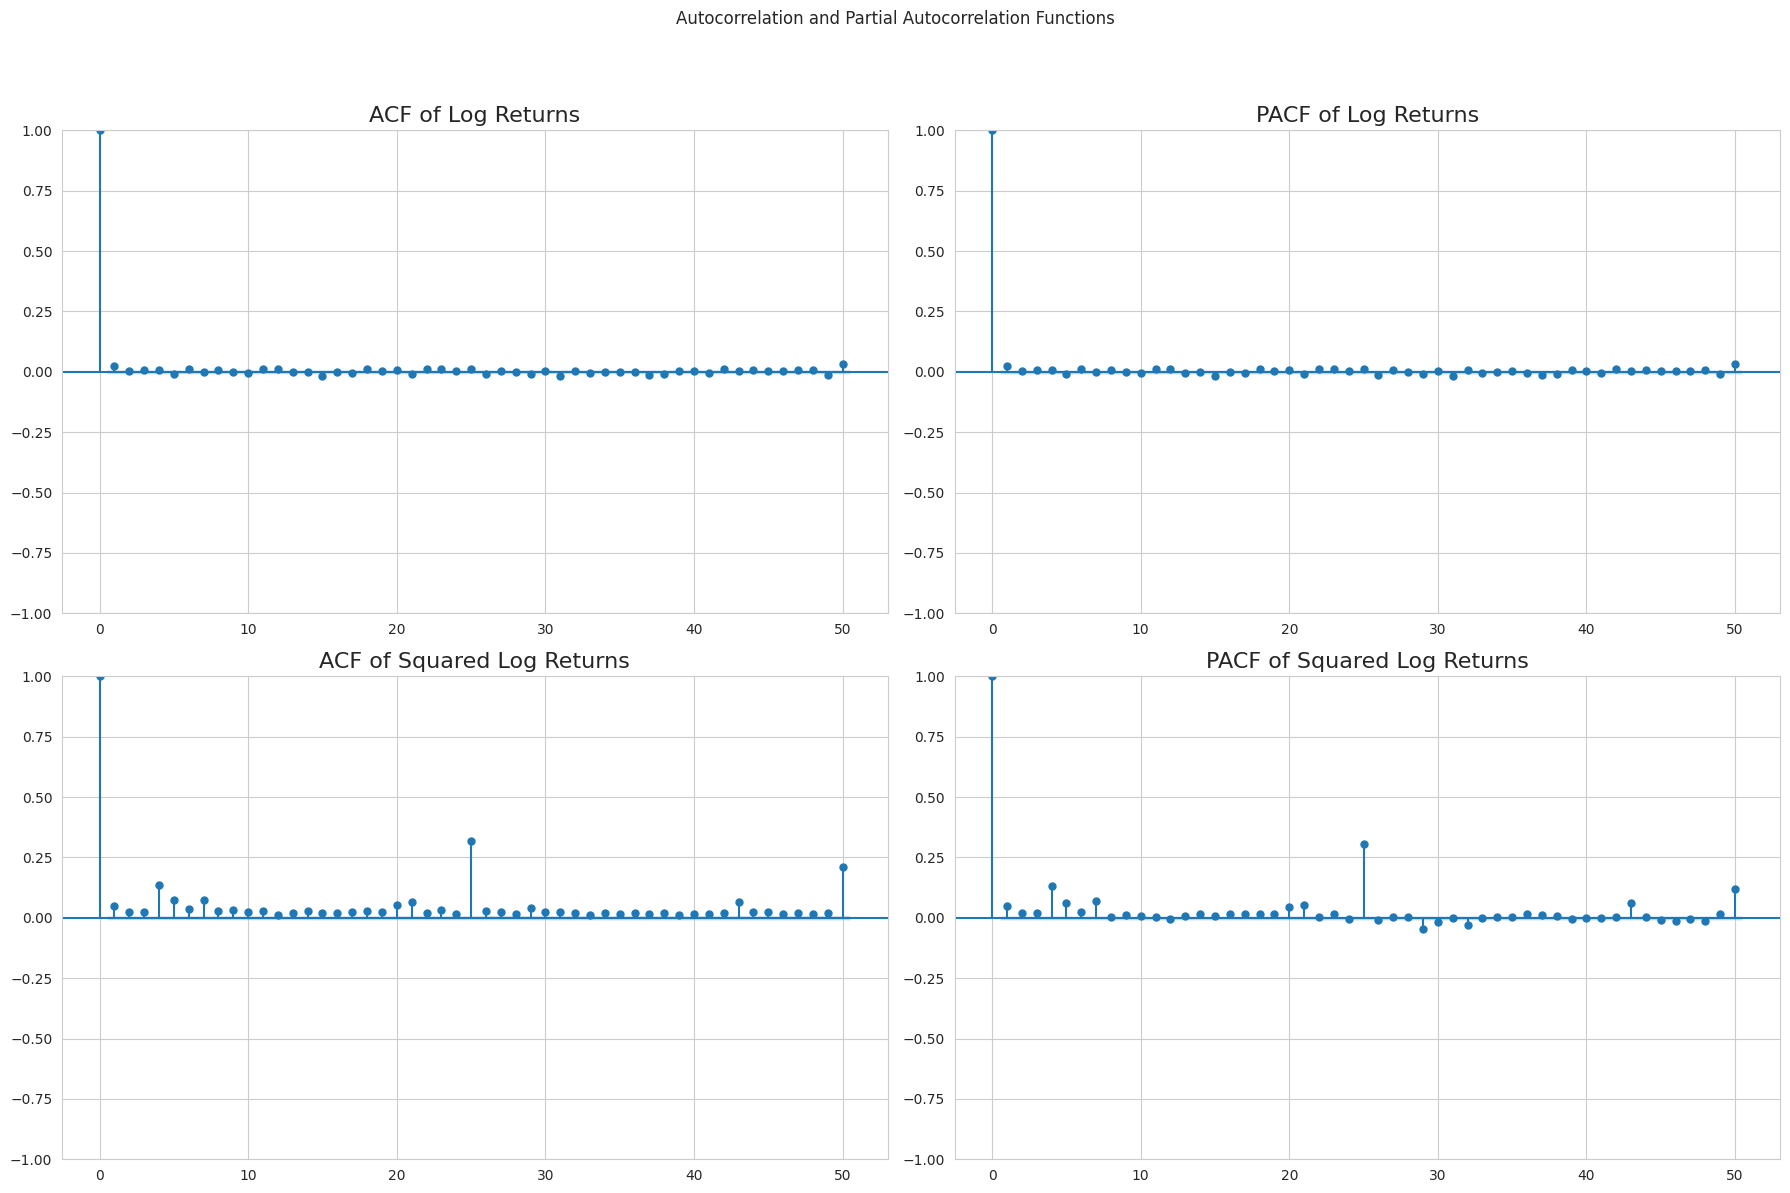

Interpretation: Significant spikes in ACF/PACF of squared returns indicate volatility clustering, suggesting GARCH is appropriate.


In [20]:
# Cell 4: ACF and PACF Plots (Adapted from original notebook)
print("--- Autocorrelation Analysis ---")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# ACF and PACF for Log Returns
plot_acf(log_returns, lags=50, ax=axes[0, 0], title='ACF of Log Returns')
plot_pacf(log_returns, lags=50, ax=axes[0, 1], title='PACF of Log Returns')

# ACF and PACF for Squared Log Returns (to check for ARCH effects)
plot_acf(log_returns**2, lags=50, ax=axes[1, 0], title='ACF of Squared Log Returns')
plot_pacf(log_returns**2, lags=50, ax=axes[1, 1], title='PACF of Squared Log Returns')

plt.suptitle('Autocorrelation and Partial Autocorrelation Functions', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("Interpretation: Significant spikes in ACF/PACF of squared returns indicate volatility clustering, suggesting GARCH is appropriate.")

In [ ]:
# Cell 5: Fitting AR(1)-GARCH(1,1) Model (Corrected for TypeError: 'lags_ma')
print("--- Fitting AR(1)-GARCH(1,1) Model ---")

# Scale returns by 100 for better numerical stability during optimization
scaled_log_returns = log_returns * 100


model = arch_model(scaled_log_returns, mean='ARX', lags=1, vol='Garch', p=1, q=1, dist='t')

print("Fitting AR(1)-GARCH(1,1) model...")
results = model.fit(disp='off') # disp='off' to suppress iteration details

print("\n--- AR(1)-GARCH(1,1) Model Summary ---")
print(results.summary())

print("\nInterpretation of key parameters:")
param_names = results.params.index.tolist()

if 'ar.L1' in param_names:
    print(f"AR(1) (mean model): {results.params['ar.L1']:.4f} (p-value: {results.pvalues['ar.L1']:.4f})")
else:
    print("AR(1) term not found in model results (possibly insignificant).")


print(f"Omega (volatility constant): {results.params['omega']:.6f} (p-value: {results.pvalues['omega']:.4f})")
print(f"Alpha[1] (ARCH term): {results.params['alpha[1]']:.4f} (p-value: {results.pvalues['alpha[1]']:.4f})")
print(f"Beta[1] (GARCH term): {results.params['beta[1]']:.4f} (p-value: {results.pvalues['beta[1]']:.4f})")

if 'nu' in param_names: # nu is present for 't' distribution
    print(f"Nu (t-distribution degrees of freedom): {results.params['nu']:.4f} (p-value: {results.pvalues['nu']:.4f})")

sum_alpha_beta = results.params['alpha[1]'] + results.params['beta[1]']
print(f"Sum of Alpha + Beta: {sum_alpha_beta:.4f}")
if sum_alpha_beta >= 1:
    print("Warning: Sum of alpha + beta >= 1, indicating high persistence or potential non-stationarity in variance.")

# Store conditional volatility and standardized residuals for diagnostics (scaled back)
conditional_volatility = results.conditional_volatility / 100
standardized_residuals = results.resid / results.conditional_volatility

--- Fitting AR(1)-GARCH(1,1) Model ---
Fitting AR(1)-GARCH(1,1) model...

--- AR(1)-GARCH(1,1) Model Summary ---
                              AR - GARCH Model Results                              
Dep. Variable:                        Close   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                14545.2
Distribution:      Standardized Student's t   AIC:                          -29078.3
Method:                  Maximum Likelihood   BIC:                          -29024.7
                                              No. Observations:                56769
Date:                      Fri, May 23 2025   Df Residuals:                    56767
Time:                              00:48:36   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          

In [22]:
# Cell 6: Forecasting Conditional Volatility (Adapted from original notebook)
print("--- Forecasting Conditional Volatility ---")

# Forecast for a specific horizon (e.g., next 50 periods = 12.5 hours)
forecast_horizon = 50 
print(f"Forecasting for the next {forecast_horizon} periods ({forecast_horizon * 15} minutes)...")

# The .forecast() method returns forecasts for mean and variance
forecasts = results.forecast(horizon=forecast_horizon, reindex=True)

# Extract forecasted conditional standard deviation and mean (scaled back)
predicted_std_dev = np.sqrt(forecasts.variance.iloc[-1]).values / 100
predicted_mean = forecasts.mean.iloc[-1].values / 100

# Create a time index for the forecasts
last_data_point_time = log_returns.index[-1]
forecast_index = pd.date_range(start=last_data_point_time, periods=forecast_horizon + 1, freq=resample_freq)[1:]

# Create a DataFrame for the forecasts
forecast_df = pd.DataFrame({
    'Forecasted_Volatility': predicted_std_dev,
    'Forecasted_Mean': predicted_mean
}, index=forecast_index)

print("\nForecasted Volatility and Mean (Head):")
print(forecast_df.head())
print("\nForecasted Volatility and Mean (Tail):")
print(forecast_df.tail())

--- Forecasting Conditional Volatility ---
Forecasting for the next 50 periods (750 minutes)...

Forecasted Volatility and Mean (Head):
                     Forecasted_Volatility  Forecasted_Mean
2024-03-22 14:45:00               0.001714         0.000025
2024-03-22 15:00:00               0.001741         0.000023
2024-03-22 15:15:00               0.001768         0.000023
2024-03-22 15:30:00               0.001794         0.000023
2024-03-22 15:45:00               0.001819         0.000023

Forecasted Volatility and Mean (Tail):
                     Forecasted_Volatility  Forecasted_Mean
2024-03-23 02:00:00               0.002410         0.000023
2024-03-23 02:15:00               0.002418         0.000023
2024-03-23 02:30:00               0.002426         0.000023
2024-03-23 02:45:00               0.002434         0.000023
2024-03-23 03:00:00               0.002441         0.000023


--- Plotting Forecasted Conditional Volatility ---


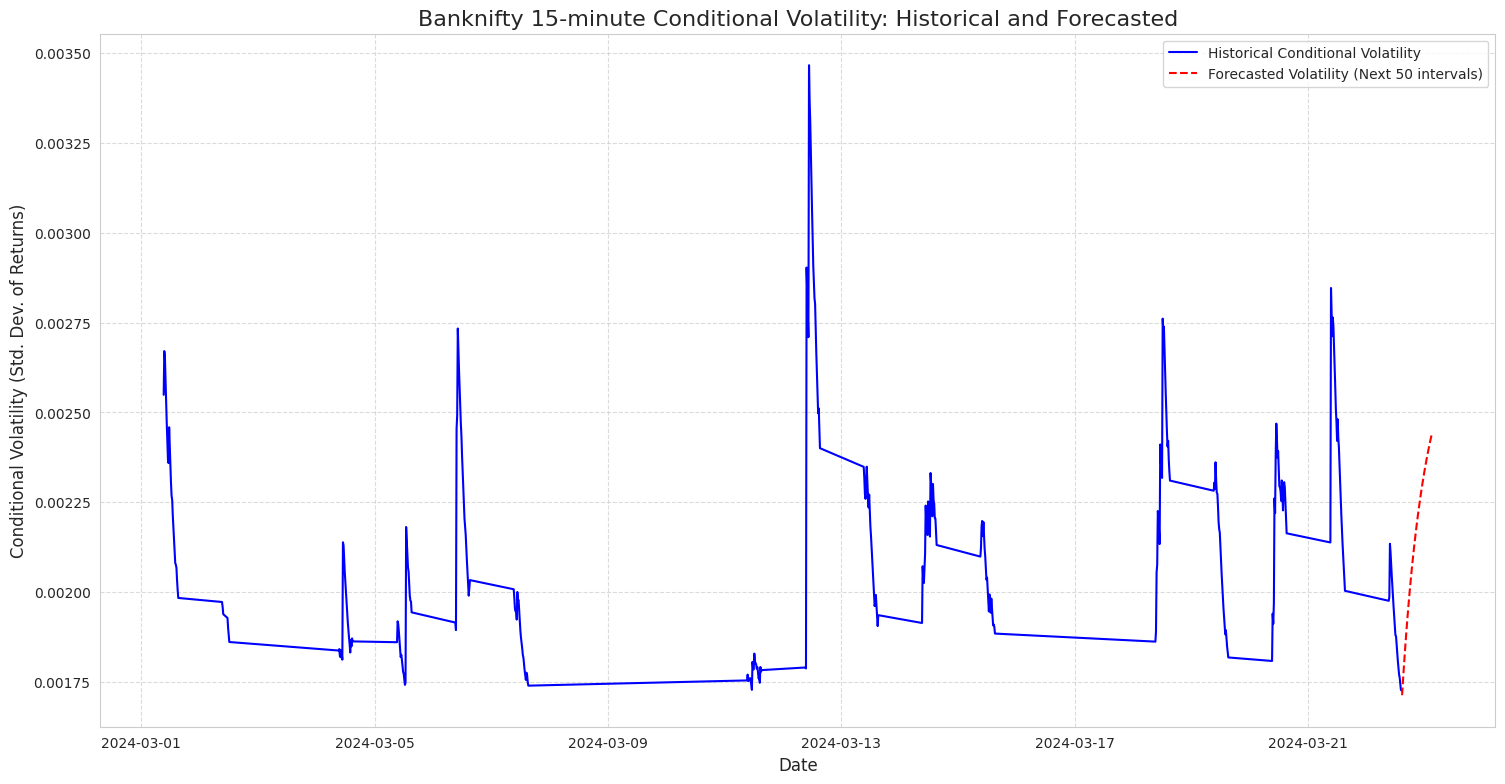


--- ARMA-GARCH Modeling Complete --- 


In [23]:
# Cell 7: Plotting Forecasted Conditional Volatility (Adapted from original notebook)
print("--- Plotting Forecasted Conditional Volatility ---")

plt.figure(figsize=(18, 9))

# Plot recent historical conditional volatility for context
recent_start_date = '2024-03-01' # Adjust this to show relevant recent history
plt.plot(conditional_volatility.loc[recent_start_date:], label='Historical Conditional Volatility', color='blue', linewidth=1.5)

# Plot the forecasted conditional volatility
plt.plot(forecast_df.index, forecast_df['Forecasted_Volatility'], 
         label=f'Forecasted Volatility (Next {forecast_horizon} intervals)', 
         color='red', linestyle='--', linewidth=1.5)

plt.title('Banknifty 15-minute Conditional Volatility: Historical and Forecasted')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility (Std. Dev. of Returns)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

print("\n--- ARMA-GARCH Modeling Complete --- ")